# K-Means Clustering Implementation   
## Liam Quinlan
CS 339   
Dr. Kretchmar

### Importing packages

In [253]:
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path
import pandas as pd

datadir = "data"

### K-Means function

In [254]:
def kmeans(data, k):
    # Initialization
    centers = np.zeros((k,data.shape[1]))
    new_centers = centers
    distances = np.ones((k,data.shape[0]))

    sample_indices = np.random.choice(data.shape[0], k, replace=False)
    centers = data[sample_indices]
    # print("Centers:\n", centers, "\n")

    # Learning
    for _ in range(20):
        # Compute Distances
        for x in range(k):
            for y in range(0,data.shape[0]):
                distance = np.linalg.norm(centers[x] - data[y])
                distances[x][y] = distance
        # print("Distances:\n", distances)

        # Identify closest clusters
        clusters = np.argmin(distances,axis=0)
        # print("Clusters:\n", clusters)

        # Update centers
        for z in range(k):
            new_centers[z] = np.array(data[clusters == z].mean(axis=0))
        # print("New Centers:\n", new_centers, "\n")

        # Check for repeat centers
        # does_array_repeat = centers == new_centers
        # if np.all(does_array_repeat) == True:
        #     break

        centers = new_centers

    return centers, clusters

In [255]:
def normalize(data):
    normalized_columns = []

    for x in range(0,data.shape[1]):
        column = data[:,x]

        min = np.min(column)
        column = column - min

        max = np.max(column)
        column = column / max

        normalized_columns.append(column)

    normalized_data = np.stack(normalized_columns, axis=1)

    return normalized_data

In [256]:
def standardize(data):
    standardized_columns = []

    for x in range(0,data.shape[1]):
        column = data[:,x]

        mean = np.mean(column)
        st_dev = np.std(column)

        column = (column - mean) / st_dev

        standardized_columns.append(column)

    standardized_data = np.stack(standardized_columns, axis=1)

    return standardized_data

In [257]:
def calculate_mse(data, centers, clusters):
    average_standard_error_list = []
    cluster_size_list = []

    # calculate mse for each cluster
    for x in range(0,centers.shape[0]):        
        data_by_cluster = data[clusters == x]
        cluster_size = data_by_cluster.shape[0]

        deviations = data_by_cluster - centers[x]
        variances = np.var(deviations, axis=0)

        standard_errors = np.sqrt(variances) / np.sqrt(cluster_size)

        average_standard_error = np.mean(standard_errors)

        average_standard_error_list.append(average_standard_error)
        cluster_size_list.append(cluster_size)

    # calculate weighted average of mses
    for y in range(len(cluster_size_list)):
        average_standard_error_list[y] = average_standard_error_list[y] * cluster_size_list[y]

    std_err_sum = np.sum(average_standard_error_list)
    
    mean_standard_error = std_err_sum / data.shape[0]
        
    return mean_standard_error

In [270]:
def kmeans_wrapper(data, k, n):
    mse_list = np.empty(0)
    centers_list = []
    
    for _ in range(n):
        centers, clusters = kmeans(data, k)
        mse = calculate_mse(data, centers, clusters)
        mse_list = np.append(mse_list, mse)
        centers_list.append(centers)
        
        print("MSE: ", mse)
        print("Centers:\n", centers, "\n")

    min_mse_index = np.argmin(mse_list)
    min_mse = np.min(mse_list)
    best_centers = centers_list[min_mse_index]

    return min_mse, best_centers

In [259]:
def elbow_plot(data, n):
    k_vs_mse_list = np.empty((0,2)) 

    for k in range(1, n+1):
        centers, clusters = kmeans(data, k)
        mse = calculate_mse(data, centers, clusters)
        k_vs_mse = np.array([k, mse])
        k_vs_mse_list = np.append(k_vs_mse_list, [k_vs_mse], axis=0)

    print(k_vs_mse_list)

    plt.scatter(k_vs_mse_list[:,0], k_vs_mse_list[:,1])
    plt.show()

    return

### Testing K-Means on a small dataset

In [260]:
# initialize data
data1 = np.array([[1,2],[1,3],[1,5],[2,3],[2,1],[6,7],[5,6],[5,9],[7,6],[8,6]])
print(data1)

[[1 2]
 [1 3]
 [1 5]
 [2 3]
 [2 1]
 [6 7]
 [5 6]
 [5 9]
 [7 6]
 [8 6]]


In [261]:
centers, clusters = kmeans(data1, 2)

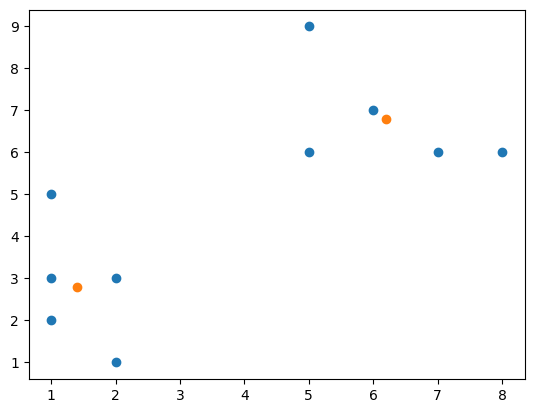

In [262]:
plt.scatter(data1[:, 0], data1[:, 1])
plt.scatter(centers[:, 0], centers[:, 1])

plt.show()

### Performing Cluster Analysis on S&P500 market data to encourage diversification

In [263]:
def readData(filepath):
    file = open(filepath, 'r')

    LoL = []

    for line in file:
        vals = line.strip().split(',')
        temp_list = []
        for val in vals:
            temp_list.append(val)
        LoL.append(temp_list)

    file.close()

    return LoL

In [264]:
listOfLists = readData(os.path.join(datadir, "financials.csv"))

financialsDF = pd.DataFrame(listOfLists)

financialsDF

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings
1,MMM,3M Company,Industrials,222.89,24.31,2.3328617,7.92,259.77,175.49,138721055226,9048000000,4.3902707,11.34,http://www.sec.gov/cgi-bin/browse-edgar?action...
2,AOS,A.O. Smith Corp,Industrials,60.24,27.76,1.1479592,1.7,68.39,48.925,10783419933,601000000,3.5754826,6.35,http://www.sec.gov/cgi-bin/browse-edgar?action...
3,ABT,Abbott Laboratories,Health Care,56.27,22.51,1.9089824,0.26,64.6,42.28,102121042306,5744000000,3.7404804,3.19,http://www.sec.gov/cgi-bin/browse-edgar?action...
4,ABBV,AbbVie Inc.,Health Care,108.48,19.41,2.4995599,3.29,125.86,60.05,181386347059,10310000000,6.291571,26.14,http://www.sec.gov/cgi-bin/browse-edgar?action...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,XYL,Xylem Inc.,Industrials,70.24,30.94,1.1700794,1.83,76.81,46.86,12915021000,722000000,2.7262094,5.31,http://www.sec.gov/cgi-bin/browse-edgar?action...
502,YUM,Yum! Brands Inc,Consumer Discretionary,76.3,27.25,1.7970798,4.07,86.93,62.85,27003303098,2289000000,6.3136363,212.08,http://www.sec.gov/cgi-bin/browse-edgar?action...
503,ZBH,Zimmer Biomet Holdings,Health Care,115.53,14.32,0.7948336,9.01,133.49,108.17,24454698119,2007400000,3.1648953,2.39,http://www.sec.gov/cgi-bin/browse-edgar?action...
504,ZION,Zions Bancorp,Financials,50.71,17.73,1.480933,2.6,55.61,38.43,10670678640,0,3.7945793,1.42,http://www.sec.gov/cgi-bin/browse-edgar?action...


In [265]:
financialsDFClean = financialsDF.copy()

financialsDFClean.drop([0,1,2,3,4,6,7,8,10,11,12,13], axis=1, inplace=True)
financialsDFClean.drop([0], axis=0, inplace=True)

lf = lambda string_to_float: float(string_to_float)

financialsDFClean[5] = financialsDFClean[5].apply(lf)
financialsDFClean[9] = financialsDFClean[9].apply(lf)

financialsDFClean

,5,9
1,2.332862,1.387211e+11
2,1.147959,1.078342e+10
3,1.908982,1.021210e+11
4,2.499560,1.813863e+11
5,1.714470,9.876586e+10
...,...,...
501,1.170079,1.291502e+10
502,1.797080,2.700330e+10
503,0.794834,2.445470e+10
504,1.480933,1.067068e+10


In [266]:
financials_array = financialsDFClean.to_numpy()

print(financials_array)

[[2.33286170e+00 1.38721055e+11]
 [1.14795920e+00 1.07834199e+10]
 [1.90898240e+00 1.02121042e+11]
 ...
 [7.94833600e-01 2.44546981e+10]
 [1.48093300e+00 1.06706786e+10]
 [6.82372030e-01 3.59911098e+10]]


In [267]:
financials_array = normalize(financials_array)

print(financials_array)

[[0.18425287 0.16866774]
 [0.09066752 0.01010968]
 [0.15077426 0.12330793]
 ...
 [0.06277713 0.02705302]
 [0.11696628 0.00996995]
 [0.05389475 0.04135055]]


In [268]:
centers, clusters = kmeans(financials_array, 10)

print(centers)

[[0.28404375 0.02372419]
 [0.48207311 0.02065839]
 [0.12899934 0.30024244]
 [0.03196904 0.10176529]
 [0.27841188 0.22483314]
 [0.08005633 0.02600643]
 [0.00304102 0.01845037]
 [0.04547138 0.85832173]
 [0.14296062 0.02778998]
 [0.19555422 0.05875756]]


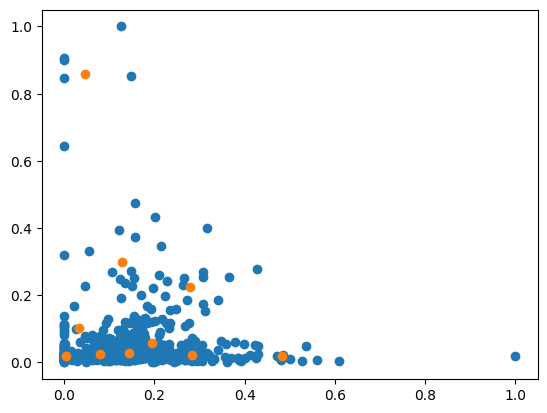

In [269]:
plt.scatter(financials_array[:, 0], financials_array[:, 1])
plt.scatter(centers[:,0], centers[:,1])

plt.show()